In [1]:
### Import Packages ###
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf


%matplotlib widget


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [9]:
lab_data = np.genfromtxt("Lab_data.csv",delimiter=',')
lab_data = np.delete(lab_data,0,0)
x_obs = lab_data[:,0]
u_obs = lab_data[:,1]-92.0 #shift everything down by 92 degrees. Closer to 1 = Faster Learning

x_obs_sub=x_obs[x_obs < 0] #Split the data set: _sub for x<0, _pcd for x>0
u_obs_sub=u_obs[x_obs < 0]

x_obs_pcd=x_obs[x_obs > 0]
u_obs_pcd=u_obs[x_obs > 0]

In [22]:
##########################################################
### This block: Set up the model. Geometry, governing  ###
### equation(s), BC's, training points                 ###
##########################################################


### Define geometry and material properties
l_pcd=2.286 #Length of PCD
l_sub=10.93 #Length of Substrate
#temp_amb=20.0-92.0 #Ambient temperature (for convection)
flux=dde.Variable(1.0) #The Flux--it's constant here
#h=dde.Variable(1.0) #Convection coefficient to solve for
k_pcd=dde.Variable(5.0)
k_sub=1 #substrate conductivity
T_base = -1 #Temperature at base of substrate
T_top = 1 #Temperature at top of PCD table

### Define Geometry ###
geom_sub = dde.geometry.Interval(-l_sub,0)
geom_pcd = dde.geometry.Interval(0,l_pcd)
#geom = dde.geometry.Interval(-l_sub,l_pcd)

################################################################
### Governing Equation and Boundary Definition: Both Domains ###
################################################################

def pde(x,u): #This function can be used for both domains   
    du_xx = dde.grad.hessian(u,x,i=0,j=0) #This equation is valid everywhere
    return du_xx 
    
### Define location of Interface at x=0: ###
def interface(x, on_boundary):
    return on_boundary and np.isclose(x[0],0)

### Define location of Interface at x=+0
# def boundary_r(x, on_boundary):
#     return on_boundary and np.isclose(x[0],0)

##################################
### BC's and PDE for substrate ###
##################################

### Define function to return du/dx = -flux/k_sub @ x =-0
def robin_sub_interface(x,y):
    return -flux/k_sub

### Define Robin BC on sub side of interface ###
### This could be a Neumann BC, but Robin BC automatically takes
### derivative normal to surface, which will be useful 
### in 2D cases down the road.

bc_sub_0 = dde.icbc.RobinBC(geom_sub, robin_sub_interface, interface)

### Define lab data as a PointSetBC
observe_u_sub = dde.icbc.PointSetBC(np.array(x_obs_sub).reshape(len(x_obs_sub),1),np.array(u_obs_sub).reshape(len(u_obs_sub),1),component=0)

### Then, the pde problem is: ###

data_sub = dde.data.PDE(geom_sub, pde,[bc_sub_0,observe_u_sub] , 14, 1, num_test=32) #bc_r

##################################
### BC's and PDE for Diamond   ###
##################################


Compiling model...
Building feed-forward neural network...
'build' took 0.175749 s



C:\Users\alebaron\AppData\Local\Programs\Python\Python39\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Tensor("Less_7:0", shape=(None, 1), dtype=bool)
Tensor("Less_8:0", shape=(None, 1), dtype=bool)
'compile' took 1.525155 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.37e-02, nan, 1.28e-01]         [8.52e-02, nan, 1.28e-01]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 1.387725 s



ValueError: x, y, and format string must not be None

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
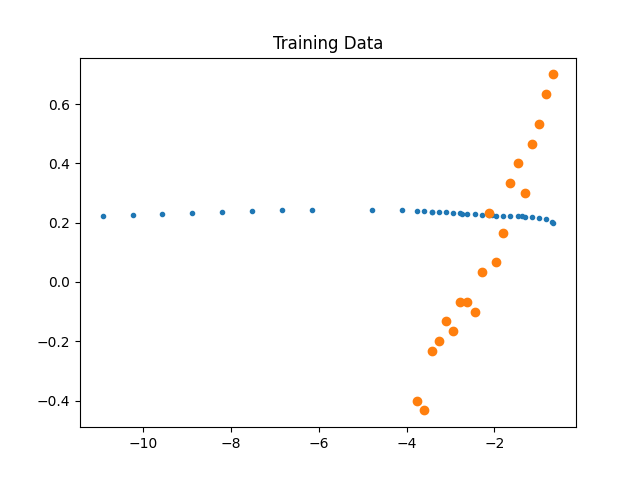

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
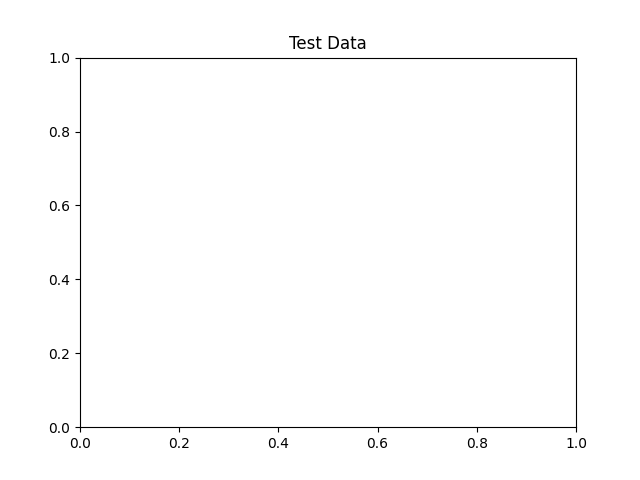

In [23]:
#######################################
### This block builds the model and ###
### trains the neural network       ###
#######################################
hidden_layer_size=20
num_hidden_layers=10
activation='tanh'
learning_rate=0.001
num_epochs=10000

### Build Model ###
layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

#### These lines apply hard boundary condition 
# def  output_transform(x, y):
#     return (1 - x) * y + 100

# net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform
# is non-physical, arbitrary, but it doesn't matter because the PINN will calculate error on the TRANSFORMED output to 
# match the governing equations and Robin (Convection) bc

model = dde.Model(data_sub, net)

### Compile Model ###
model.compile("adam", lr=learning_rate,loss_weights=[3,1,1])
variable_flux = dde.callbacks.VariableValue(flux, period=200, filename="variable_flux.dat")
variable_kpcd = dde.callbacks.VariableValue(k_pcd, period=200, filename="variable_kpcd.dat")

### Train Model ###
losshistory, train_state = model.train(epochs=num_epochs, callbacks=[variable_flux, variable_kpcd]) 

### Plot and save output ###
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

plt.figure()
plt.title('Training Data')
plt.plot(train_state.X_train,train_state.y_pred_train,'.')
plt.plot(x_obs_sub,u_obs_sub,'o')
plt.figure()
plt.title('Test Data')
plt.plot(train_state.X_test,train_state.best_y,'.')
plt.plot(x_obs_sub,u_obs_sub,'o')
plt.legend(['best_y','lab data'])

In [19]:
# plt.figure()
# plt.title('Training Data')
# plt.plot(train_state.X_train,train_state.y_pred_train,'.')
# plt.plot(x_obs,u_obs,'o')
# plt.figure()
# plt.title('Test Data')
# plt.plot(train_state.X_test,train_state.best_y,'.')
# plt.plot(x_obs,u_obs,'o')
# plt.legend(['best_y','lab data'])

print(variable_flux.value)
print(variable_kpcd.value)

[0.91497993]
[5.0]


In [6]:
#### Building and Training, but in a for loop! Neato. ####
'''
hidden_layer_sizes=[20]
nums_hidden_layers=[10]
activation='tanh'
learning_rate=0.001
num_epochs=10000

for hidden_layer_size in hidden_layer_sizes:
    for num_hidden_layers in nums_hidden_layers:
        ### Build Model ###
        layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc
        initializer = "Glorot uniform"
        net = dde.nn.FNN(layer_size, activation, initializer)

        #### These lines apply hard boundary condition 
        def  output_transform(x, y):
            return (1 - x) * y + 100

        net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform
        # is non-physical, arbitrary, but it doesn't matter because the PINN will calculate error on the TRANSFORMED output to 
        # match the governing equations and Robin (Convection) bc. This is weird but I see why it works.

        model = dde.Model(data, net)

        ### Compile Model ###
        model.compile("adam", lr=learning_rate)

        ### Train Model ###
        losshistory, train_state = model.train(epochs=num_epochs) #losshistory, train_state = 
        
        ### Plot and save output ###
        fileprefix=str('HLSIZE'+str(hidden_layer_size)+'NHL'+str(num_hidden_layers)+'ACT'+activation+'LR'+str(learning_rate))
        dde.saveplot(losshistory, train_state, issave=True, isplot=True,
                     loss_fname=fileprefix+'loss.dat',
                     train_fname=fileprefix+'train.dat',
                     test_fname=fileprefix+'test.dat')
        
        #Training Time
        #Iteration of best state
        #x_test, y hat at best state
        #Train Loss @ best state
        #Test Loss @ best state

# plt.figure()
# plt.plot(train_state.X_train,train_state.y_pred_train,'.')
# plt.plot(train_state.X_test,train_state.best_y,'.')
# plt.legend(['Y_pred_train','best_y'])
'''

'\nhidden_layer_sizes=[20]\nnums_hidden_layers=[10]\nactivation=\'tanh\'\nlearning_rate=0.001\nnum_epochs=10000\n\nfor hidden_layer_size in hidden_layer_sizes:\n    for num_hidden_layers in nums_hidden_layers:\n        ### Build Model ###\n        layer_size = [1] + [hidden_layer_size] * num_hidden_layers + [1] #First layer is [1] for 1d problem, [2] for 2d problem, etc\n        initializer = "Glorot uniform"\n        net = dde.nn.FNN(layer_size, activation, initializer)\n\n        #### These lines apply hard boundary condition \n        def  output_transform(x, y):\n            return (1 - x) * y + 100\n\n        net.apply_output_transform(output_transform) #The network output is transformed so that u(1)=100 always. The transform\n        # is non-physical, arbitrary, but it doesn\'t matter because the PINN will calculate error on the TRANSFORMED output to \n        # match the governing equations and Robin (Convection) bc. This is weird but I see why it works.\n\n        model = dde.